## Image segmentation of Synthetic Unity data

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
path = Path('captures')
path.ls()

[WindowsPath('captures/train'), WindowsPath('captures/val')]

## Data

In [5]:
fnames = list((path/'train').glob('*img*'))
fnames[:3]

[WindowsPath('captures/train/image_00001_img.png'),
 WindowsPath('captures/train/image_00002_img.png'),
 WindowsPath('captures/train/image_00003_img.png')]

In [6]:
lbl_names = list((path/'train').glob('*layer*'))
lbl_names[:3]

[WindowsPath('captures/train/image_00001_layer.png'),
 WindowsPath('captures/train/image_00002_layer.png'),
 WindowsPath('captures/train/image_00003_layer.png')]

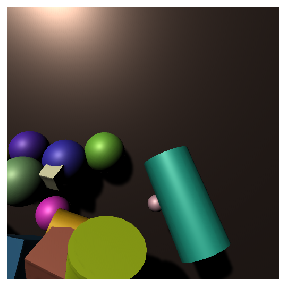

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: str(x).replace('img', 'layer')

In [9]:
open_image(get_y_fn(img_f), convert_mode='L').data.unique()

tensor([0.0000, 0.0157, 0.0196, 0.0314, 0.0353, 0.0392])

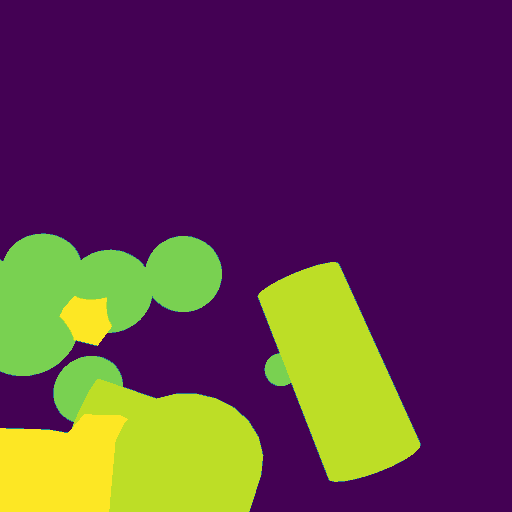

In [10]:
mask = open_mask(get_y_fn(img_f))
mask

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([512, 512]),
 tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [10, 10, 10,  ...,  0,  0,  0],
          [10, 10, 10,  ...,  0,  0,  0],
          [10, 10, 10,  ...,  0,  0,  0]]]))

In [12]:
codes = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "Cube", "Sphere", "Cylinder"])

## Datasets

In [13]:
size = src_size//2
bs=8

In [14]:
def just_images(x):
    return 'img' in str(x)

src = (SegmentationItemList.from_folder(path)
     .filter_by_func(just_images)
     .split_by_folder(train='train', valid='val')
     .label_from_func(get_y_fn, classes=codes))
src

LabelLists;

Train: LabelList (1999 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: captures;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: captures;

Test: None

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

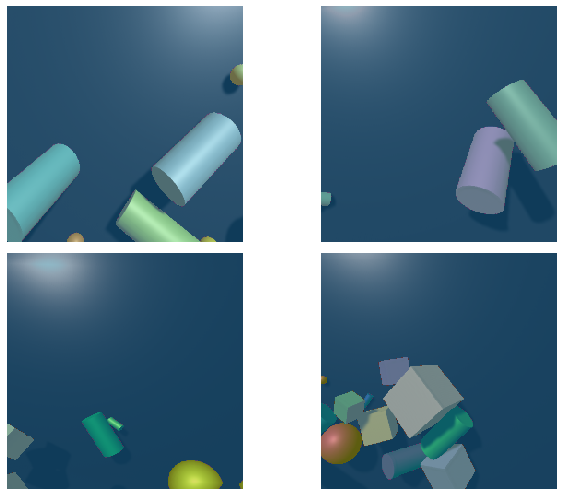

In [16]:
data.show_batch(2, figsize=(10,7))

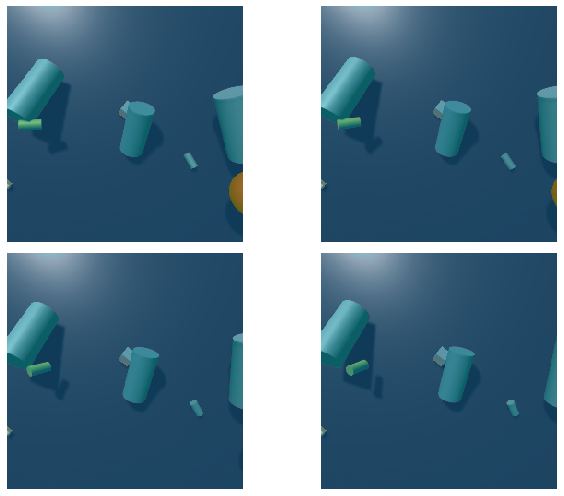

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_segmentation(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics=acc_segmentation

In [20]:
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\antpc/.cache\torch\checkpoints\resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_segmentation,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


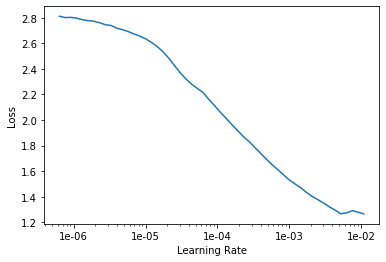

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=1e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_segmentation,time
0,0.147793,0.087673,0.834903,01:35
1,0.091607,0.064888,0.871484,01:37
2,0.073032,0.051141,0.933584,01:37
3,0.065973,0.050221,0.920900,01:40
4,0.060729,0.050014,0.905178,01:40
5,0.050072,0.031620,0.945048,01:42
6,0.044664,0.039148,0.916911,01:34
7,0.041266,0.033917,0.931202,01:39
8,0.038453,0.028787,0.941127,01:38
9,0.028520,0.022306,0.957007,01:38


In [26]:
learn.save('stage-1')

In [27]:
learn.load('stage-1');

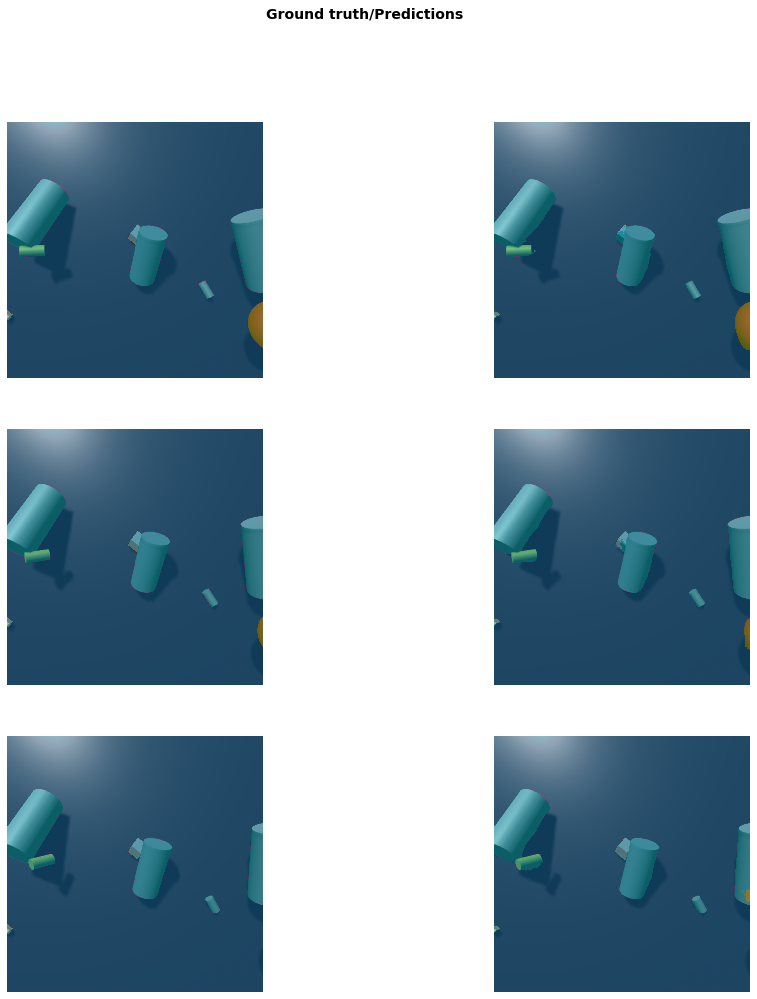

In [28]:
learn.show_results(rows=3, figsize=(16,16))

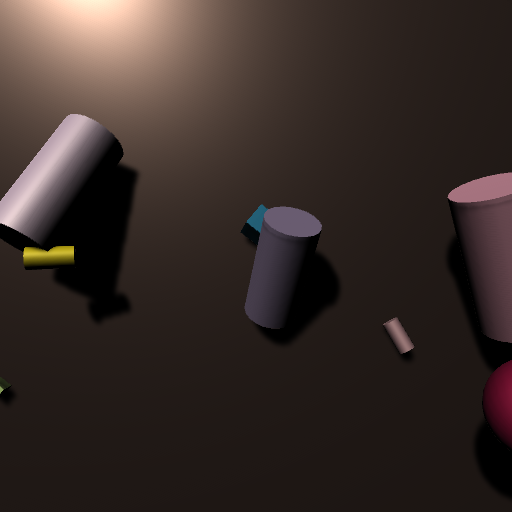

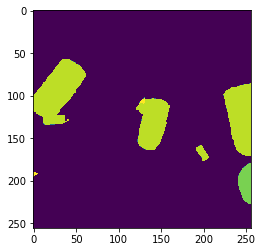

In [29]:
img = open_image((path/'val').ls()[0])
display(img)
plt.imshow(learn.predict(img)[1].squeeze())

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_segmentation,time


KeyboardInterrupt: 

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=3

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin